In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import xgboost as xgb
from imblearn.over_sampling import SMOTE

In [26]:
dataset = pd.read_csv("/content/Fraud.csv")

In [27]:
dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [29]:
dataset['amount'] = dataset['amount'].fillna(dataset['amount'].median())

In [30]:
print(dataset.isnull().sum())

step              0
type              1
amount            0
nameOrig          1
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


In [33]:
# Fill numeric missing with median
num_cols = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
for col in num_cols:
    dataset[col] = dataset[col].fillna(dataset[col].median())

# Fill categorical with mode
dataset['type'] = dataset['type'].fillna(dataset['type'].mode()[0])

# Drop rows with missing target values
dataset = dataset.dropna(subset=['isFraud', 'isFlaggedFraud'])

In [35]:
print(dataset.isnull().sum())

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [37]:
dataset = dataset.drop(["isFlaggedFraud"], axis=1)

In [38]:
# Encode categorical column 'type'
dataset = pd.get_dummies(dataset, columns=["type"], drop_first=True)

In [39]:
# Features (X) and Target (y)
X = dataset.drop("isFraud", axis=1)
y = dataset["isFraud"]

# Drop rows with NaN values in the target variable
nan_rows = y.isna()
X = X[~nan_rows]
y = y[~nan_rows]

In [40]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [41]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [44]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"
)

model.fit(X_train_res, y_train_res)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:55:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

In [45]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]



In [54]:
from sklearn.metrics import  precision_score,recall_score, f1_score
best_threshold = 0.5
best_f1 = 0

for t in np.arange(0.1, 0.91, 0.01):  # thresholds from 0.1 to 0.9
    y_pred = (y_pred_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

# Step 3: Evaluate at best threshold
y_pred_final = (y_pred_proba >= best_threshold).astype(int)

print(f"✅ Best Threshold: {best_threshold:.2f}")
print(f"Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_final):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_final):.4f}")

cm = confusion_matrix(y_test, y_pred_final)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, digits=4))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

✅ Best Threshold: 0.90
Precision: 0.7214
Recall: 0.9106
F1-score: 0.8050

Confusion Matrix:
[[464337    185]
 [    47    479]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9999    0.9996    0.9998    464522
         1.0     0.7214    0.9106    0.8050       526

    accuracy                         0.9995    465048
   macro avg     0.8606    0.9551    0.9024    465048
weighted avg     0.9996    0.9995    0.9995    465048

ROC-AUC Score: 0.995422341667774


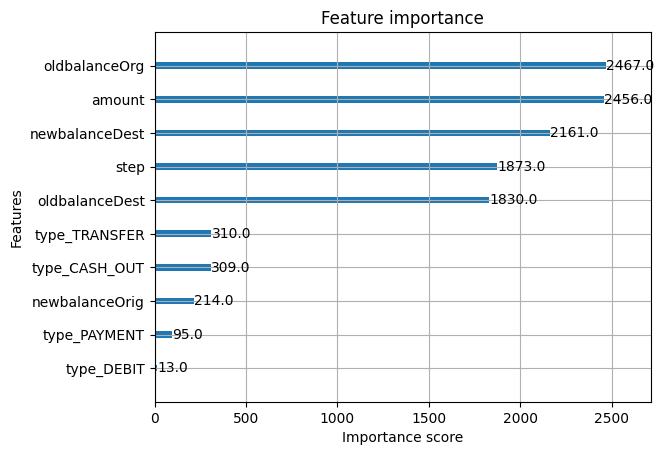

In [55]:
# Feature Importance
xgb.plot_importance(model, max_num_features=10)
plt.show()